## Transfer Learning with TensorFlow, scaling up (🍔👀Food Vision mini)

We've seen the power of transfer learning feature extraction and fine_tuning, now it's time to scale up to all of the classes in food101 (101 totl classes of food).

Our goual is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).

Original Food101 paper [here](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf).

Our baseline to beat is 50.76% accuracy across 101 classes

In [1]:
# Check connection
!nvidia-smi

Thu Jan 25 18:21:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions

Download the helper functions

In [2]:
!wget https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py

--2024-01-25 18:21:40--  https://raw.githubusercontent.com/JonasHagstrom79/Tensorflow/main/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10235 (10.0K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  10.00K  --.-KB/s    in 0s      

2024-01-25 18:21:40 (112 MB/s) - ‘helper.py’ saved [10235/10235]



In [3]:
# Import series of helper functions for our notebook
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 FoodClasses: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the [image_data_modification](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) notebook.

In [4]:
# Get the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-01-25 18:21:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.207, 142.251.10.207, 142.251.12.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  19.6MB/s    in 74s     

2024-01-25 18:22:58 (20.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macarons'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/guacamole'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gnocchi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/takoyaki'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cannoli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_clas

In [6]:
# Set up data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we´re going to take:
* Create a `ModelCheckpoint` callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # To save time, if False it'll take alot of time to sve the whole model
                                                         monitor="val_accuracy",
                                                         save_best_only=True) # Saves the best weights for val_accuracy

In [8]:
# Create data augmentation layer (If we put it into the model the augmentation will happen o the GPU wich is faster)
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Set up data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1/255.) # Can be skipped when using EfficieNet models (built in)
], name="data_augmentation")

In [9]:
# Setup the base model and freeze it layers (this will extrac features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False;

# Setup model arcitecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the bas model in inference mode so weights wich needs to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="blobal_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # Output neurons = 101(classes)
# Create the model
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


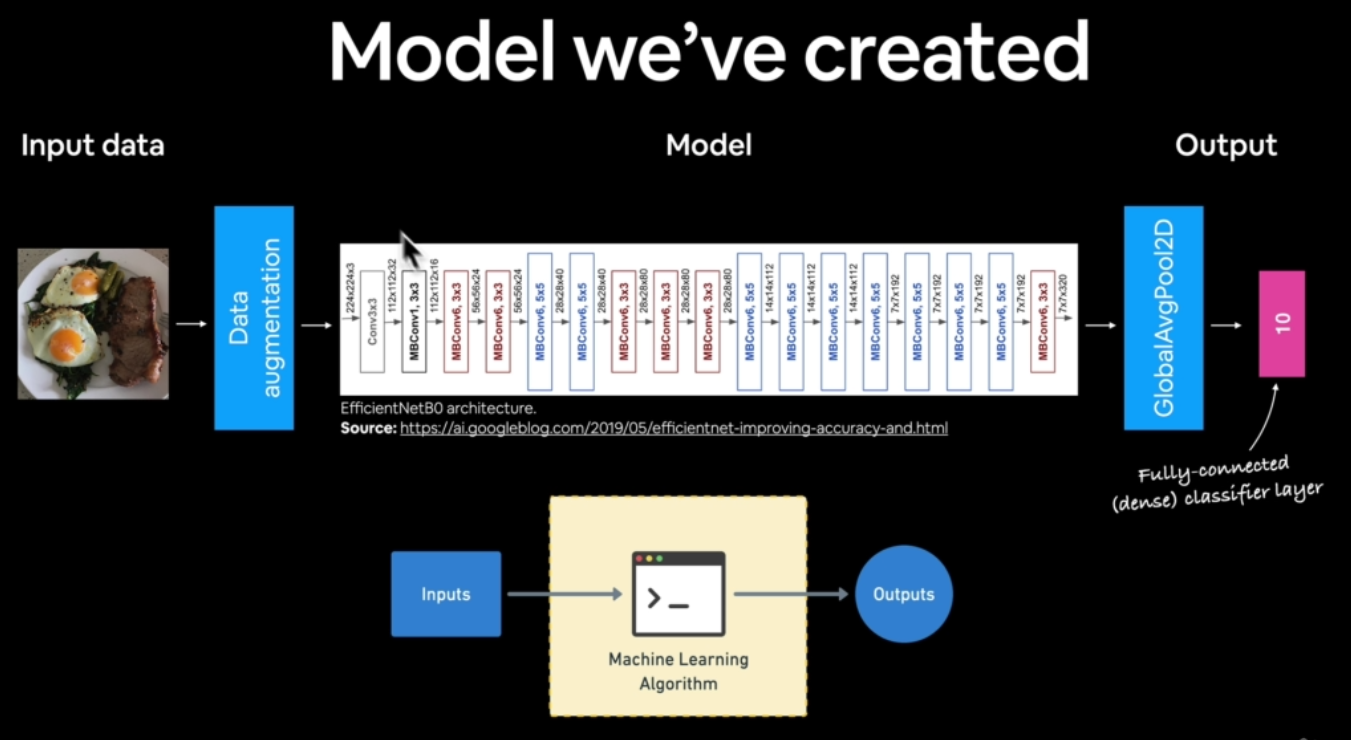

In [10]:
# Get a summmary of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 blobal_avg_pool_layer (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs for quick exp
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 149s 589ms/step - loss: 3.3878 - accuracy: 0.2692 - val_loss: 2.4663 - val_accuracy: 0.4701
Epoch 2/5
237/237 [==============================] - 94s 396ms/step - loss: 2.1952 - accuracy: 0.4999 - val_loss: 2.0141 - val_accuracy: 0.5257
Epoch 3/5
237/237 [==============================] - 84s 355ms/step - loss: 1.8347 - accuracy: 0.5596 - val_loss: 1.8888 - val_accuracy: 0.5381
Epoch 4/5
237/237 [==============================] - 73s 308ms/step - loss: 1.6028 - accuracy: 0.6195 - val_loss: 1.7874 - val_accuracy: 0.5450
Epoch 5/5
237/237 [==============================] - 68s 286ms/step - loss: 1.4653 - accuracy: 0.6399 - val_loss: 1.7357 - val_accuracy: 0.5524


In [12]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 49s 61ms/step - loss: 1.5813 - accuracy: 0.5831


[1.5813266038894653, 0.5831286907196045]

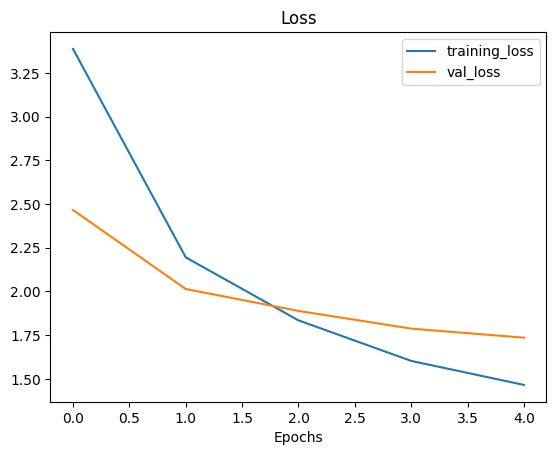

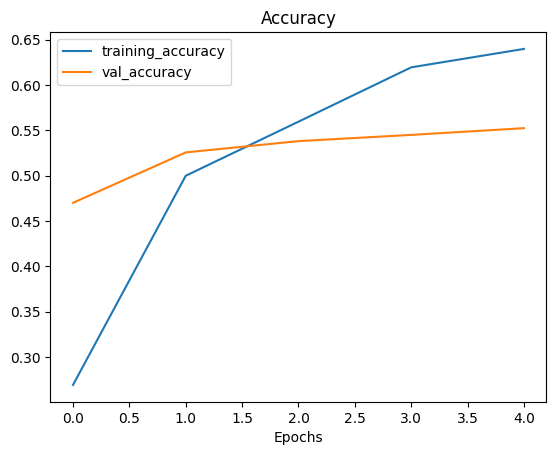

In [13]:
# Plot loss curves, overfitting :P
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [14]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False


In [15]:
# Recompile model with lower learning rate (best practice to lower lr when unfreeze layers)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              metrics=["accuracy"])

In [16]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
blobal_avg_pool_layer True
output_layer True


In [17]:
# Check wich layres are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [18]:
# Fine tune for 5 more epochs were we left off last traning
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

# Refit the model
history_fine_tune_all_classes_ten_percent = model.fit(train_data_all_10_percent,
                                                           epochs=fine_tune_epochs,
                                                           validation_data=test_data,
                                                           validation_steps=int(0.15 * len(test_data)),
                                                           initial_epoch=history_all_classes_10_percent.epoch[-1],
                                                           callbacks=[create_tensorboard_callback(dir_name="transfer_lerning", # Not necessary
                                                                                                  experiment_name="10_percent_all_classes_last_five_layers_fine_tuned")])

Saving TensorBoard log files to: transfer_lerning/10_percent_all_classes_last_five_layers_fine_tuned/20240125-183155
Epoch 5/10
237/237 [==============================] - 72s 273ms/step - loss: 1.4886 - accuracy: 0.6034 - val_loss: 1.7122 - val_accuracy: 0.5644
Epoch 6/10
237/237 [==============================] - 57s 240ms/step - loss: 1.0820 - accuracy: 0.6993 - val_loss: 1.7532 - val_accuracy: 0.5506
Epoch 7/10
237/237 [==============================] - 56s 236ms/step - loss: 0.8393 - accuracy: 0.7637 - val_loss: 1.9297 - val_accuracy: 0.5283
Epoch 8/10
237/237 [==============================] - 51s 214ms/step - loss: 0.6653 - accuracy: 0.8069 - val_loss: 1.9032 - val_accuracy: 0.5326
Epoch 9/10
237/237 [==============================] - 50s 208ms/step - loss: 0.5277 - accuracy: 0.8459 - val_loss: 2.0039 - val_accuracy: 0.5339
Epoch 10/10
237/237 [==============================] - 46s 193ms/step - loss: 0.4288 - accuracy: 0.8758 - val_loss: 2.2157 - val_accuracy: 0.4989


In [19]:
# Evaluate the fine tuned model
results_fine_tune_10_percent_all_classes = model.evaluate(test_data)
results_fine_tune_10_percent_all_classes

790/790 [==============================] - 48s 61ms/step - loss: 1.8437 - accuracy: 0.5638


[1.8437385559082031, 0.5638415813446045]

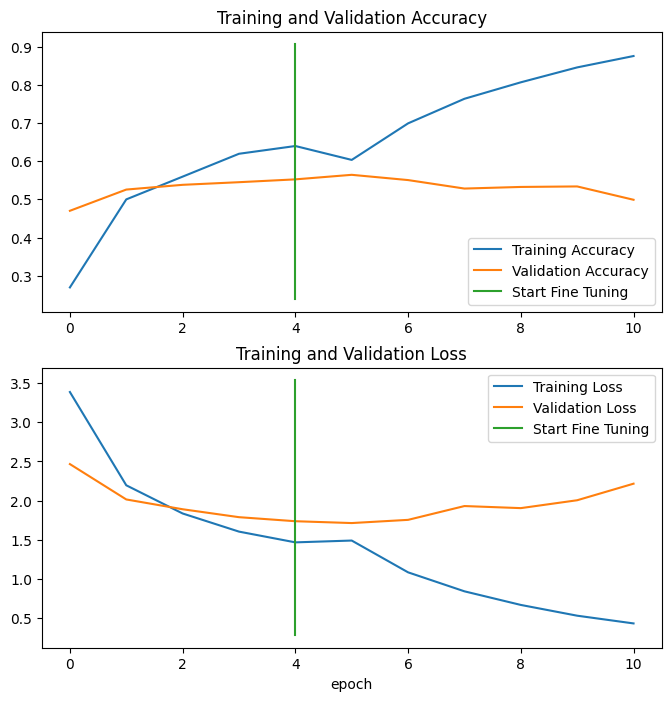

In [20]:
# Check the loss curves, model is overfittning on the training data
compare_historys(history_all_classes_10_percent,
                 history_fine_tune_all_classes_ten_percent,
                 initial_epochs=5)

## Saving and loading our model

To use our model in an external application, we'll need to save it and export it somewhere.

In [21]:
# save our fine-tuning model (to google drive)
model.save("drive/MyDrive/TensorFlow/101_foof_classes_10_percent_saved_model")

In [22]:
# Load and evaluate saved model
loaded_model = tf.keras.models.load_model("drive/MyDrive/TensorFlow/101_foof_classes_10_percent_saved_model")

In [23]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 51s 63ms/step - loss: 1.8437 - accuracy: 0.5638


[1.8437385559082031, 0.5638415813446045]

In [24]:
# The results from our loaded model (above) should be very similar to the results below
results_fine_tune_10_percent_all_classes

[1.8437385559082031, 0.5638415813446045]

## Evaluating the performance of the model across different classes

Let's make predictions, visualize them and later find out wich predictions were the "most" wrong.

In [25]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbose to see how long is left

790/790 [==============================] - 46s 57ms/step


In [26]:
len(test_data)

790

In [27]:
# How many predictions are there?
len(preds_probs)

25250

In [28]:
# Whats the shape of our predictions?
preds_probs.shape

(25250, 101)

In [29]:
# Let's see what the 10 first predictions look like
preds_probs[:10]

array([[8.2577866e-01, 1.7764158e-06, 4.2269398e-03, ..., 5.4301641e-08,
        1.4155195e-03, 9.1530965e-05],
       [9.9729854e-01, 5.2608651e-10, 2.3411494e-05, ..., 1.6655796e-04,
        8.2216278e-09, 2.5256852e-09],
       [1.3393648e-01, 9.3083940e-03, 3.6324715e-04, ..., 3.1195232e-04,
        1.8131456e-04, 1.6188497e-02],
       ...,
       [7.2671521e-01, 2.7184546e-08, 1.3971050e-05, ..., 3.9311578e-03,
        1.4670160e-05, 1.4649167e-06],
       [5.9922510e-01, 5.2247797e-05, 4.5774087e-02, ..., 2.9237461e-04,
        3.9234947e-04, 1.1935278e-04],
       [4.8998809e-01, 1.7914506e-06, 1.7401547e-04, ..., 2.0724521e-03,
        1.4400437e-06, 6.5162336e-03]], dtype=float32)

In [30]:
# What does the first prediction probability array looks like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([8.25778663e-01, 1.77641584e-06, 4.22693975e-03, 9.83806014e-09,
        1.27256968e-07, 5.50619239e-09, 8.19809884e-06, 2.22694556e-08,
        1.13904197e-03, 2.91495053e-05, 5.09713018e-08, 3.53260907e-06,
        1.61600583e-05, 6.52852172e-09, 3.89464094e-06, 2.92237569e-03,
        1.24041133e-08, 6.82910422e-06, 2.09046830e-03, 6.85446048e-06,
        1.42067393e-05, 2.59088750e-07, 2.95402720e-06, 1.83128723e-04,
        3.77777033e-04, 7.54733454e-04, 9.70250494e-06, 2.84248472e-07,
        2.74835108e-03, 4.34317008e-06, 1.26866473e-08, 5.20455469e-05,
        9.20737239e-06, 2.01433128e-08, 9.93635971e-04, 7.64322436e-08,
        4.34269595e-07, 1.80077095e-05, 3.57271201e-04, 2.01231245e-07,
        1.47254889e-06, 4.09613451e-04, 2.75250204e-05, 1.54594381e-05,
        3.14638760e-06, 1.16488422e-06, 9.70747060e-05, 3.48877052e-06,
        1.60031206e-07, 1.07534446e-01, 5.26761960e-06, 5.08607172e-07,
        1.51311625e-02, 1.69602688e-03, 6.30203544e-07, 1.916812

Our model outputs a prediction probability array (with N number of variables, where N is the number of classes) for each sample passed to the predict method.

In [31]:
# We get one pred probability per class( in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [8.25778663e-01 1.77641584e-06 4.22693975e-03 9.83806014e-09
 1.27256968e-07 5.50619239e-09 8.19809884e-06 2.22694556e-08
 1.13904197e-03 2.91495053e-05 5.09713018e-08 3.53260907e-06
 1.61600583e-05 6.52852172e-09 3.89464094e-06 2.92237569e-03
 1.24041133e-08 6.82910422e-06 2.09046830e-03 6.85446048e-06
 1.42067393e-05 2.59088750e-07 2.95402720e-06 1.83128723e-04
 3.77777033e-04 7.54733454e-04 9.70250494e-06 2.84248472e-07
 2.74835108e-03 4.34317008e-06 1.26866473e-08 5.20455469e-05
 9.20737239e-06 2.01433128e-08 9.93635971e-04 7.64322436e-08
 4.34269595e-07 1.80077095e-05 3.57271201e-04 2.01231245e-07
 1.47254889e-06 4.09613451e-04 2.75250204e-05 1.54594381e-05
 3.14638760e-06 1.16488422e-06 9.70747060e-05 3.48877052e-06
 1.60031206e-07 1.07534446e-01 5.26761960e-06 5.08607172e-07
 1.51311625e-02 1.69602688e-03 6.30203544e-07 1.91681276e-04
 1.23038888e-03 1.50274267e-04 2.14053830e-

In [32]:
test_data.class_names[0]

'apple_pie'

In [33]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 0,  0,  8,  8,  0,  9, 29,  0,  0,  0])

In [34]:
# How many pred clases do we have?
len(pred_classes)

25250

Now we'vegot a predictions array of all of our models predictions, to evaluate them, we need to compare them to original test dataset


In [35]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # Currently test labels look llike-. [0, 0, 0, 1, ..... 0, 0], we want the index value where the "1" occurs
y_labels[:10] # Look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [36]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array is in the same orde as our test labels array is to find the accuracy score

In [37]:
results_fine_tune_10_percent_all_classes

[1.8437385559082031, 0.5638415813446045]

In [38]:
# Let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true = y_labels,
                                  y_pred = pred_classes)

sklearn_accuracy

0.5638415841584158

In [39]:
# Does this metric come close to our model's evaluate results?
import numpy as np
np.isclose(results_fine_tune_10_percent_all_classes[1], sklearn_accuracy)

True

## Let's get visual: making a configuration matrix


## Let's get visual: making a confusion matrix

In [42]:
# Import helper function
from helper import make_confusion_matrix

In [43]:
# Get  list of class names
class_names= test_data.class_names
# Print out 10
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [45]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20)